Import os, sys, time, Tensorflow, Tensorflow docs, numpy, and matplotlib packages

In [14]:
from time import time
import sys
import os
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

import PIL.Image

import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)
import matplotlib.pyplot as plt

Loading cifar10 dataset, and split training and testing dataset

In [93]:
(train_img, train_lb), (test_img, test_lb) = datasets.cifar10.load_data()

data normalization (convert image pixel values to values bertween 0 an 1, this dataset is simpler than other dataset since the image is already in numpy array format)

In [94]:
t0 = time()
train_img, test_img = train_img / 255.0, test_img / 255.0
dur = time() - t0
print("Normalization takes %fs" % dur)

Normalization takes 0.563023s


Since cifar 10 dataset from tensorflow.dataset does not contain label name, we have to use data description from cifar 10 resource page to manually create a label name index to understand data label

In [95]:
lb_name = {0: 'airplane', 1: 'automobile', 2:'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

visualizing data

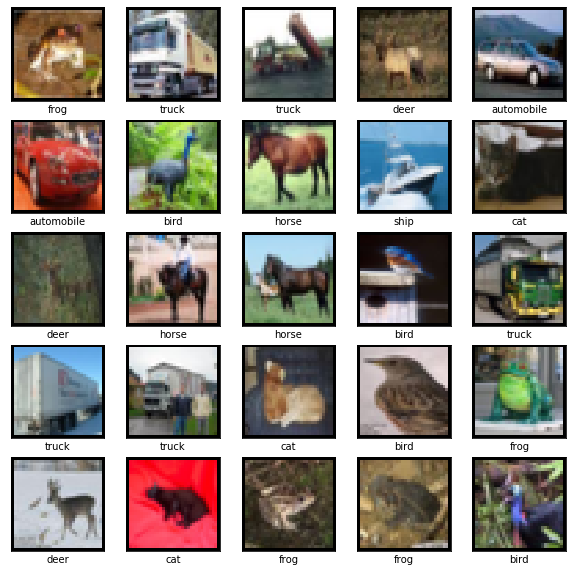

In [118]:
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(pad_train_img[i], cmap = plt.cm.binary)
    plt.xlabel(lb_name[train_lb[i][0]])
plt.show()

Pad original training dataset (to reduce edge effect when passing through filters)

In [117]:
pad_train_img = tf.pad(train_img, [[0,0], [1,1], [1,1], [0,0]], "CONSTANT")

image augmentation function to add noise to original training datasets

In [ ]:
def augment(img, lb):
    

Visualization function to check image before and after augmentation

In [28]:
def visualize_aug(org, aug):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(org)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(aug)

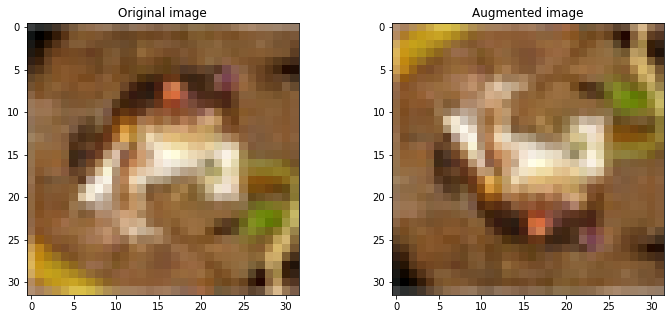

In [80]:
rt_ud = tf.image.random_flip_up_down(train_img[0])
visualize_aug(train_img[0], rt_ud)

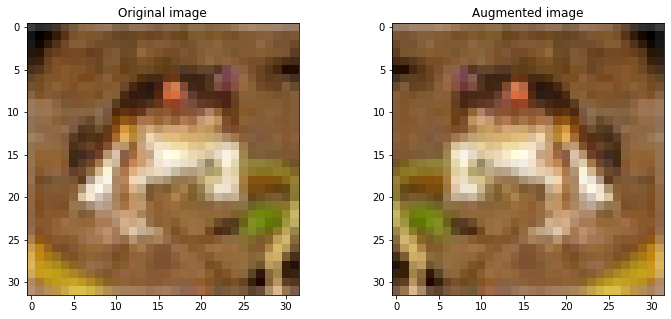

In [82]:
rt_lr = tf.image.random_flip_left_right(train_img[0])
visualize_aug(train_img[0], rt_lr)

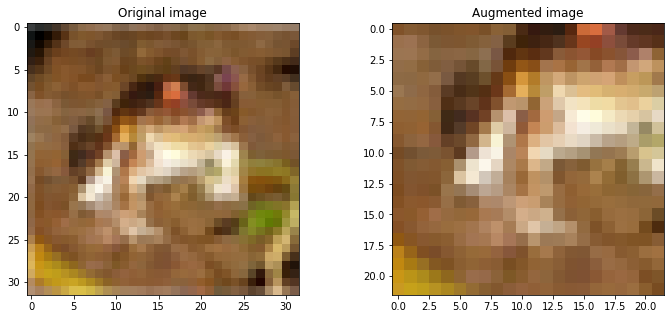

In [81]:
ccrop = tf.image.random_crop(train_img[0], [22, 22, 3])
visualize_aug(train_img[0], ccrop)

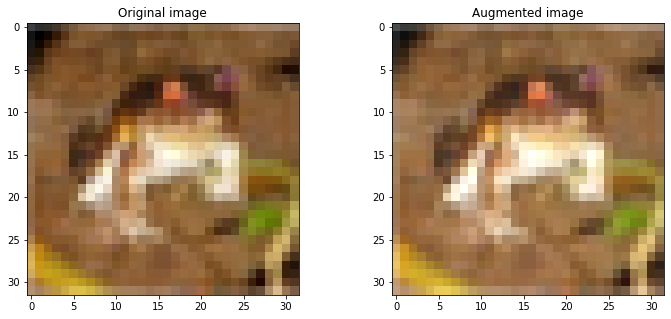

In [78]:
brt = tf.image.random_brightness(train_img[0], 0.6)
visualize_aug(train_img[0], brt)

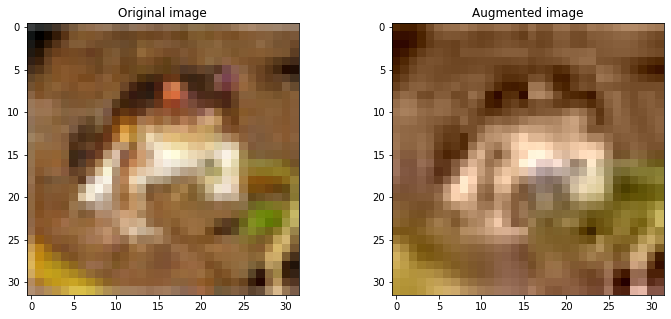

In [57]:
qlt = tf.image.random_jpeg_quality(train_img[0], 20, 80)
visualize_aug(train_img[0], qlt)

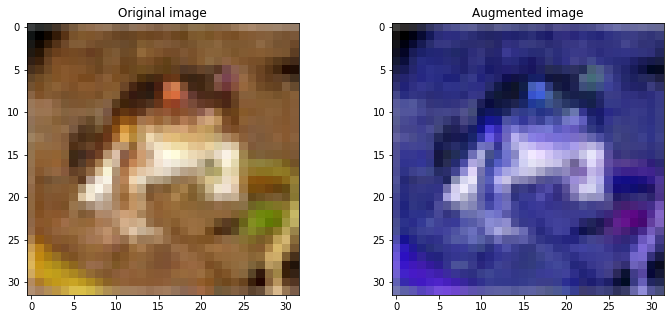

In [83]:
rhue = tf.image.random_hue(train_img[0], 0.5)
visualize_aug(train_img[0], rhue)

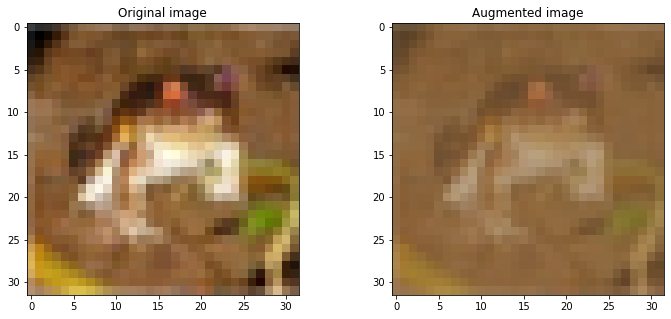

In [85]:
rcontrast = tf.image.random_contrast(train_img[0], 0.0, 0.6)
visualize_aug(train_img[0], rcontrast)

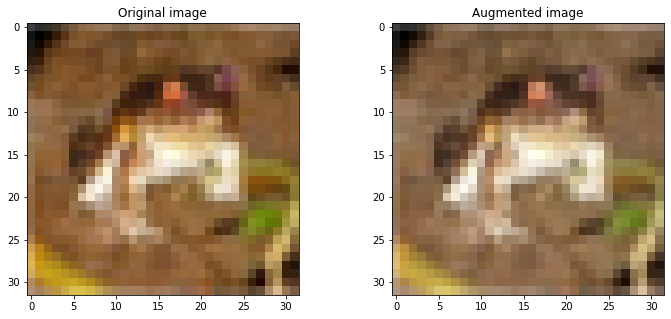

In [86]:
rsat = tf.image.random_saturation(train_img[0], 0.0, 0.8)
visualize_aug(train_img[0], rsat)

In [130]:
model = tf.keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10)
])

In [131]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [133]:
model.compile(optimizer='RMSprop',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

report = model.fit(train_img,
                   train_lb,
                   epochs = 20,
                   validation_data=(test_img, test_lb))

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 30s 599us/sample - loss: 1.5237 - accuracy: 0.4518 - val_loss: 1.2980 - val_accuracy: 0.5414
Epoch 2/20
50000/50000 [==============================] - 30s 591us/sample - loss: 1.1186 - accuracy: 0.6036 - val_loss: 1.0916 - val_accuracy: 0.6228
Epoch 3/20
50000/50000 [==============================] - 29s 590us/sample - loss: 0.9584 - accuracy: 0.6648 - val_loss: 1.2389 - val_accuracy: 0.5822
Epoch 4/20
50000/50000 [==============================] - 29s 589us/sample - loss: 0.8554 - accuracy: 0.7023 - val_loss: 0.9771 - val_accuracy: 0.6730
Epoch 5/20
50000/50000 [==============================] - 30s 592us/sample - loss: 0.7789 - accuracy: 0.7287 - val_loss: 0.9304 - val_accuracy: 0.6910
Epoch 6/20
50000/50000 [==============================] - 29s 588us/sample - loss: 0.7203 - accuracy: 0.7507 - val_loss: 0.9046 - val_accuracy: 0.6975
Epoch 7/20
50000/50000 [====================

In [134]:
test_loss, test_acc = model.evaluate(test_img, test_lb, verbose=2)
print(test_acc)

10000/10000 - 2s - loss: 1.6395 - accuracy: 0.6938
0.6938
